In [105]:
import pandas as pd

In [106]:
data_path = 'data/NOVADENT/'

pases_radio_df = pd.read_csv(data_path + 'pasesradio.csv', sep=';', encoding='utf-8', decimal=',', parse_dates=['fecha', 'fechamod'], dayfirst=True)
pases_tv_df = pd.read_csv(data_path + 'pasestv.csv', sep=';', encoding='utf-8', decimal=',', parse_dates=['fecha', 'fechamod'], dayfirst=True)

In [107]:

# Also load 'Altas pacientes acumulado.xlsx'
altas_pacientes_df = pd.read_excel(data_path + 'Altas pacientes acumulado.xlsx')

In [108]:
pases_radio_df.head()

,id,pase,campana,cadena,ambitos,fecha,dia,hora,dur,pb2,nb2,tipo,formato,contactos,grp,grps,coste,fechamod
0,8221,EL PIRATA Y SU BANDA,NOVADENT,ROCK FM CADENA,NACIONAL,2018-02-12,LUNES,08:11:08,20,1,7,CU�A CONVENCIONAL,CU�A CONVENCIONAL,73401.24,0.4,0.4,210.0,2018-02-12 08:11:08.000
1,8222,MARTA VAZQUEZ,NOVADENT,ROCK FM CADENA,NACIONAL,2018-02-12,LUNES,11:05:17,20,1,1,CU�A CONVENCIONAL,CU�A CONVENCIONAL,73401.24,0.4,0.4,187.6,2018-02-12 11:05:17.000
2,8223,MARTA VAZQUEZ,NOVADENT,ROCK FM CADENA,NACIONAL,2018-02-12,LUNES,13:27:33,20,1,1,CU�A CONVENCIONAL,CU�A CONVENCIONAL,55050.93,0.3,0.3,187.6,2018-02-12 13:27:33.000
3,8224,RAUL CARNICERO,NOVADENT,ROCK FM CADENA,NACIONAL,2018-02-12,LUNES,18:01:30,20,1,1,CU�A CONVENCIONAL,CU�A CONVENCIONAL,36700.62,0.2,0.2,161.0,2018-02-12 18:01:30.000
4,8225,RODRI CONTRERAS,NOVADENT,ROCK FM CADENA,NACIONAL,2018-02-12,LUNES,20:26:43,20,1,1,CU�A CONVENCIONAL,CU�A CONVENCIONAL,18350.31,0.1,0.1,161.0,2018-02-12 20:26:43.000


# Data preparation

## Pases Radio

## `pases_radio_df` — columnas (qué es cada cosa)

Cada fila parece representar **un pase/emisión** de una cuña de la campaña `NOVADENT` en una cadena de radio.

- `id`: identificador del pase (entero).
- `pase`: nombre del bloque/programa o identificador editorial del pase (texto).
- `campana`: nombre de campaña (texto; aquí suele ser `NOVADENT`).
- `cadena`: emisora/cadena (texto).
- `ambitos`: ámbito geográfico (p.ej. `NACIONAL`).
- `fecha`: fecha del pase (datetime; viene en formato día/mes/año).
- `dia`: día de la semana en texto (p.ej. `LUNES`).
- `hora`: hora del pase como texto `HH:MM:SS`.
- `dur`: duración del spot en segundos (entero).
- `pb2`, `nb2`: contadores/indicadores de planificación/posición (enteros; significado exacto depende del proveedor).
- `tipo`: tipo de creatividad (p.ej. cuña convencional).
- `formato`: formato creativo (a menudo igual que `tipo`).
- `contactos`: contactos estimados (numérico; usa coma decimal en origen).
- `grp`, `grps`: GRP(s) estimados (numérico; normalmente `grps` es el KPI principal).
- `coste`: coste del pase (numérico).
- `fechamod`: marca temporal de modificación/ingesta (debería ser datetime).

### 1) Propuestas de recasteo (tipos)

- Convertir `cadena`, `ambitos`, `dia`, `tipo`, `formato` a `category` (reduce memoria y acelera groupbys).
- Forzar `fechamod` a datetime (a veces entra como `object` por espacios o formatos mixtos).
- Crear `emision_ts` combinando `fecha` + `hora` para análisis intra-día.
- Mantener `dur`, `pb2`, `nb2`, `id` como enteros (`Int64` si quieres tolerar NA).

### 2) Propuestas de nuevas features (ideas útiles)

- Temporales: `year`, `month`, `week`, `dayofweek`, `hour` y una `franja` (mañana/tarde/prime…).
- Eficiencia: `coste_por_grp`, `coste_por_contacto`, `contactos_por_segundo`, `grp_por_segundo`.
- Agregadas: gasto/GRPs/contactos diarios por `cadena` y rolling windows (7d/28d).
- Calidad: flags de outliers (coste muy alto por GRP) y duplicados (`id`/`emision_ts`).

In [109]:
import numpy as np
import pandas as pd

# --- Re-casteo / limpieza (in-place) ---
pases_radio_df = pases_radio_df.copy()

# A veces `fechamod` entra como object por espacios/formato
if pases_radio_df['fechamod'].dtype == 'object':
    pases_radio_df['fechamod'] = pd.to_datetime(
        pases_radio_df['fechamod'].astype(str).str.strip(),
        errors='coerce'
    )

# Categorías (útil para EDA + groupby)
for col in ['cadena', 'ambitos', 'dia', 'tipo', 'formato', 'campana']:
    if col in pases_radio_df.columns:
        pases_radio_df[col] = pases_radio_df[col].astype('category')

# Enteros “seguros” (admite NA si aparece)
for col in ['id', 'dur', 'pb2', 'nb2']:
    if col in pases_radio_df.columns:
        pases_radio_df[col] = pd.to_numeric(pases_radio_df[col], errors='coerce').astype('Int64')

# Floats “seguros”
for col in ['contactos', 'grp', 'grps', 'coste']:
    if col in pases_radio_df.columns:
        pases_radio_df[col] = pd.to_numeric(pases_radio_df[col], errors='coerce').astype('Float64')

# --- Features nuevas ---
hora_dt = pd.to_datetime(pases_radio_df['hora'], format='%H:%M:%S', errors='coerce')
pases_radio_df['hour'] = hora_dt.dt.hour.astype('Int64')
pases_radio_df['minute'] = hora_dt.dt.minute.astype('Int64')

# Timestamp completo de emisión (clave para series temporales)
pases_radio_df['emision_ts'] = pd.to_datetime(
    pases_radio_df['fecha'].dt.strftime('%Y-%m-%d') + ' ' + pases_radio_df['hora'].astype(str),
    errors='coerce'
 )

# Calendario
pases_radio_df['year'] = pases_radio_df['fecha'].dt.year.astype('Int64')
pases_radio_df['month'] = pases_radio_df['fecha'].dt.month.astype('Int64')
pases_radio_df['dayofweek'] = pases_radio_df['fecha'].dt.dayofweek.astype('Int64')
pases_radio_df['week'] = pases_radio_df['fecha'].dt.isocalendar().week.astype('Int64')

# Franjas horarias (ajústalo a tu negocio si quieres)
pases_radio_df['franja'] = pd.cut(
    pases_radio_df['hour'].astype('float'),
    bins=[-0.1, 6, 12, 18, 22, 24],
    labels=['noche', 'mañana', 'mediodía', 'tarde', 'prime'],
    include_lowest=True
).astype('category')

# Eficiencia (evitar división por cero)
grps_nonzero = pases_radio_df['grps'].mask(pases_radio_df['grps'] == 0)
contactos_nonzero = pases_radio_df['contactos'].mask(pases_radio_df['contactos'] == 0)
dur_nonzero = pases_radio_df['dur'].astype('Float64').mask(pases_radio_df['dur'] == 0)

# Normalización a 20'' (GRPs equivalentes a 20 segundos)
pases_radio_df['grps20'] = (pases_radio_df['grps'] * (20 / dur_nonzero)).astype('Float64')
grps20_nonzero = pases_radio_df['grps20'].mask(pases_radio_df['grps20'] == 0)

# Métrica principal de eficiencia: coste por GRP normalizado a 20''
pases_radio_df['coste_por_grp20'] = (pases_radio_df['coste'] / grps20_nonzero).astype('Float64')

# (Opcional) eficiencia vs GRPs sin normalizar
pases_radio_df['coste_por_grp'] = (pases_radio_df['coste'] / grps_nonzero).astype('Float64')
pases_radio_df['coste_por_contacto'] = (pases_radio_df['coste'] / contactos_nonzero).astype('Float64')
pases_radio_df['contactos_por_segundo'] = (pases_radio_df['contactos'] / dur_nonzero).astype('Float64')
pases_radio_df['grps_por_segundo'] = (pases_radio_df['grps'] / dur_nonzero).astype('Float64')

pases_radio_df[['fecha','hora','emision_ts','cadena','dur','grps','grps20','coste','coste_por_grp20','franja']].head()

,fecha,hora,emision_ts,cadena,dur,grps,grps20,coste,coste_por_grp20,franja
0,2018-02-12,08:11:08,2018-02-12 08:11:08,ROCK FM CADENA,20,0.4,0.4,210.0,525.0,mañana
1,2018-02-12,11:05:17,2018-02-12 11:05:17,ROCK FM CADENA,20,0.4,0.4,187.6,469.0,mañana
2,2018-02-12,13:27:33,2018-02-12 13:27:33,ROCK FM CADENA,20,0.3,0.3,187.6,625.333333,mediodía
3,2018-02-12,18:01:30,2018-02-12 18:01:30,ROCK FM CADENA,20,0.2,0.2,161.0,805.0,mediodía
4,2018-02-12,20:26:43,2018-02-12 20:26:43,ROCK FM CADENA,20,0.1,0.1,161.0,1610.0,tarde


In [110]:
pases_radio_df.describe()

,id,fecha,dur,pb2,nb2,contactos,grp,grps,coste,fechamod,...,year,month,dayofweek,week,grps20,coste_por_grp20,coste_por_grp,coste_por_contacto,contactos_por_segundo,grps_por_segundo
count,1008.0,1008,1008.0,1008.0,1008.0,1008.0,1008.0,1008.0,1008.0,1008,...,1008.0,1008.0,1008.0,1008.0,1008.0,996.0,996.0,996.0,1008.0,1008.0
mean,8724.5,2018-02-09 08:31:25.714285568,20.019841,2.795635,5.954365,153611.028909,0.837103,0.837103,309.070258,2018-02-09 21:11:07.517857024,...,2018.0,1.737103,1.396825,6.422619,0.83498,465.339462,464.864968,0.002533,7661.072446,0.041749
min,8221.0,2018-01-01 00:00:00,20.0,1.0,1.0,0.0,0.0,0.0,14.0,2018-01-01 11:27:34,...,2018.0,1.0,0.0,1.0,0.0,91.466667,91.466667,0.000498,0.0,0.0
25%,8472.75,2018-01-23 00:00:00,20.0,1.0,4.0,73401.24,0.4,0.4,137.2,2018-01-23 11:59:04.500000,...,2018.0,1.0,0.0,4.0,0.4,257.777778,257.777778,0.001405,3670.062,0.02
50%,8724.5,2018-02-13 00:00:00,20.0,2.0,6.0,110101.86,0.6,0.6,250.5,2018-02-13 14:36:31,...,2018.0,2.0,1.0,7.0,0.6,410.571429,410.571429,0.002237,5505.093,0.03
75%,8976.25,2018-02-26 00:00:00,20.0,4.0,8.0,220203.72,1.2,1.2,426.7,2018-02-26 16:07:42.750000128,...,2018.0,2.0,2.0,9.0,1.2,534.197917,525.0,0.002861,11010.186,0.06
max,9228.0,2018-03-12 00:00:00,25.0,9.0,18.0,642260.9,3.5,3.5,1308.0,2018-03-12 20:31:58,...,2018.0,3.0,6.0,11.0,3.5,3780.0,3780.0,0.020599,32113.045,0.175
std,291.128837,NaN,0.314501,1.625853,2.80974,120996.463225,0.65937,0.65937,251.656903,NaN,...,0.0,0.746613,1.153239,2.698332,0.654235,319.62336,319.519426,0.001741,6002.70344,0.032712


In [111]:
pases_radio_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     1008 non-null   Int64         
 1   pase                   1008 non-null   object        
 2   campana                1008 non-null   category      
 3   cadena                 1008 non-null   category      
 4   ambitos                1008 non-null   category      
 5   fecha                  1008 non-null   datetime64[ns]
 6   dia                    1008 non-null   category      
 7   hora                   1008 non-null   object        
 8   dur                    1008 non-null   Int64         
 9   pb2                    1008 non-null   Int64         
 10  nb2                    1008 non-null   Int64         
 11  tipo                   1008 non-null   category      
 12  formato                1008 non-null   category      
 13  con

## Pases de TV

## `pases_tv_df` — columnas (qué es cada cosa)

Cada fila representa un **pase/emisión de TV** (spot) de la campaña, con su contexto de cadena/programa y métricas de presión (GRPs).

- `id`: identificador del pase (entero).
- `campana`: campaña (texto; p.ej. `NOVADENT`).
- `mes`: mes en texto/código (p.ej. `MAR`).
- `tipo_accion`: tipo de acción (p.ej. `SPOT`).
- `grupo`: agrupación/paquete de planificación (p.ej. `A3COB`).
- `soporte`: soporte/portfolio comercial (p.ej. `ATRES COBERTURA`).
- `fecha`: fecha del pase (datetime; viene en formato día/mes/año).
- `dia`: día de la semana (texto; p.ej. `Jueves`).
- `hora_real`: hora real de emisión `HH:MM:SS` (texto).
- `dur`: duración del spot en segundos (entero).
- `pb2`, `nb2`: contadores/indicadores de planificación/posición (enteros; significado exacto depende del proveedor).
- `programa`: programa/bloque donde se emite (texto).
- `hw`: audiencia/indicador tipo rating (numérico; suele venir con coma decimal).
- `hw_can`: versión por canal o indicador relacionado (numérico).
- `franja`: franja provista por el proveedor (texto/categoría; p.ej. `MAÑ`, `SOB`, `TAR`, `NOC`).
- `dpm`: tipo de medición (p.ej. `DT`, `PT`).
- `clave_real`: clave/código interno del pase (texto; p.ej. `FE4`).
- `pos_pb2`: posición (texto/código; p.ej. `7º`).
- `cadena`: cadena/canal (texto; p.ej. `A3COB`).
- `ambito`: ámbito geográfico (texto; p.ej. `NAC`).
- `coste`: coste del pase (numérico).
- `fechamod`: timestamp de modificación/ingesta (debería ser datetime).
- `grps`: GRPs del pase (numérico).

### Propuestas de recasteo (tipos)

- Convertir a `category`: `campana`, `mes`, `tipo_accion`, `grupo`, `soporte`, `dia`, `programa`, `franja`, `dpm`, `clave_real`, `pos_pb2`, `cadena`, `ambito`.
- Forzar `fechamod` a datetime (a veces llega como `object` por espacios/formato).
- Mantener enteros (idealmente `Int64`): `id`, `dur`, `pb2`, `nb2`.
- Mantener floats (idealmente `Float64`): `hw`, `hw_can`, `grps`, `coste`.

### Propuestas de nuevas features (las que ya empezamos a crear)

- `emision_ts`: timestamp completo combinando `fecha` + `hora_real` (clave para series temporales).
- Calendario: `year`, `month_num`, `week`, `dayofweek`, `hour`, `minute`.
- `franja_calc`: franja calculada desde `hour` (útil para estandarizar, sin depender del proveedor).
- Normalización a 20'': `grps20 = grps * (20 / dur)` para comparar pases de distinta duración.
- Eficiencia principal: `coste_por_grp20 = coste / grps20` (más comparable que `coste_por_grp`).

In [112]:
# --- Re-casteo / limpieza (TV) ---
pases_tv_df = pases_tv_df.copy()

# A veces `fechamod` entra como object por espacios/formato
if 'fechamod' in pases_tv_df.columns and pases_tv_df['fechamod'].dtype == 'object':
    pases_tv_df['fechamod'] = pd.to_datetime(
        pases_tv_df['fechamod'].astype(str).str.strip(),
        errors='coerce'
    )

# Categorías (útil para EDA + groupby)
for col in [
    'campana','mes','tipo_accion','grupo','soporte','dia','programa','dpm','clave_real','pos_pb2','cadena','ambito','franja'
]:
    if col in pases_tv_df.columns:
        pases_tv_df[col] = pases_tv_df[col].astype('category')

# Enteros “seguros” (admite NA)
for col in ['id', 'dur', 'pb2', 'nb2']:
    if col in pases_tv_df.columns:
        pases_tv_df[col] = pd.to_numeric(pases_tv_df[col], errors='coerce').astype('Int64')

# Floats “seguros”
for col in ['hw', 'hw_can', 'grps', 'coste']:
    if col in pases_tv_df.columns:
        pases_tv_df[col] = pd.to_numeric(pases_tv_df[col], errors='coerce').astype('Float64')

# --- Features nuevas (TV) ---
hora_dt_tv = pd.to_datetime(pases_tv_df.get('hora_real'), format='%H:%M:%S', errors='coerce')
pases_tv_df['hour'] = hora_dt_tv.dt.hour.astype('Int64')
pases_tv_df['minute'] = hora_dt_tv.dt.minute.astype('Int64')

# Timestamp completo de emisión (fecha + hora_real)
if 'fecha' in pases_tv_df.columns and 'hora_real' in pases_tv_df.columns:
    pases_tv_df['emision_ts'] = pd.to_datetime(
        pases_tv_df['fecha'].dt.strftime('%Y-%m-%d') + ' ' + pases_tv_df['hora_real'].astype(str),
        errors='coerce'
    )

# Calendario
if 'fecha' in pases_tv_df.columns:
    pases_tv_df['year'] = pases_tv_df['fecha'].dt.year.astype('Int64')
    pases_tv_df['month_num'] = pases_tv_df['fecha'].dt.month.astype('Int64')
    pases_tv_df['dayofweek'] = pases_tv_df['fecha'].dt.dayofweek.astype('Int64')
    pases_tv_df['week'] = pases_tv_df['fecha'].dt.isocalendar().week.astype('Int64')

# Franja horaria calculada (para no pisar la columna `franja` original del fichero)
pases_tv_df['franja_calc'] = pd.cut(
    pases_tv_df['hour'].astype('float'),
    bins=[-0.1, 6, 12, 18, 22, 24],
    labels=['noche', 'mañana', 'mediodía', 'tarde', 'prime'],
    include_lowest=True
).astype('category')

# Eficiencia (evitar división por cero)
dur_nonzero_tv = pases_tv_df['dur'].astype('Float64').mask(pases_tv_df['dur'] == 0)
grps_nonzero_tv = pases_tv_df['grps'].mask(pases_tv_df['grps'] == 0)

# Normalización a 20'' (GRPs equivalentes a 20 segundos)
pases_tv_df['grps20'] = (pases_tv_df['grps'] * (20 / dur_nonzero_tv)).astype('Float64')
grps20_nonzero_tv = pases_tv_df['grps20'].mask(pases_tv_df['grps20'] == 0)

# Métrica principal de eficiencia: coste por GRP normalizado a 20''
pases_tv_df['coste_por_grp20'] = (pases_tv_df['coste'] / grps20_nonzero_tv).astype('Float64')

# (Opcional) eficiencia vs GRPs sin normalizar
pases_tv_df['coste_por_grp'] = (pases_tv_df['coste'] / grps_nonzero_tv).astype('Float64')
pases_tv_df['grps_por_segundo'] = (pases_tv_df['grps'] / dur_nonzero_tv).astype('Float64')

cols_show = [c for c in ['fecha','hora_real','emision_ts','cadena','dur','grps','grps20','coste','coste_por_grp20','franja','franja_calc','programa'] if c in pases_tv_df.columns]
pases_tv_df[cols_show].head()

,fecha,hora_real,emision_ts,cadena,dur,grps,grps20,coste,coste_por_grp20,franja,franja_calc,programa
0,2018-03-01,11:48:58,2018-03-01 11:48:58,A3COB,20,1.9,1.9,837.9,441.0,MA�,mañana,ESPEJO PUBLICO:LA ULTIMA HORA
1,2018-03-01,16:02:48,2018-03-01 16:02:48,A3COB,10,2.56,5.12,1580.544,308.7,SOB,mediodía,KARLOS ARGUI�ANO RECETA EXPRES
2,2018-03-01,18:37:41,2018-03-01 18:37:41,A3COB,20,6.08,6.08,2681.28,441.0,TAR,mediodía,EL SECRETO DE PUENTE VIEJO
3,2018-03-01,21:39:11,2018-03-01 21:39:11,A3COB,20,7.22,7.22,3184.02,441.0,NOC,tarde,EL TIEMPO 2
4,2018-03-04,22:01:36,2018-03-04 22:01:36,A3COB,10,2.715,5.43,1676.241,308.7,NOC,tarde,ANTENA 3 PRESENTA


In [113]:
# Save pases_radio_df and pases_tv_df to processed files (CSV + Parquet)
from pathlib import Path

output_dir = Path(data_path) / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

# CSV
radio_csv = output_dir / 'pases_radio_processed.csv'
tv_csv = output_dir / 'pases_tv_processed.csv'
pases_radio_df.to_csv(radio_csv, index=False)
pases_tv_df.to_csv(tv_csv, index=False)

# Parquet (try pyarrow first; fall back to fastparquet)
radio_parquet = output_dir / 'pases_radio_processed.parquet'
tv_parquet = output_dir / 'pases_tv_processed.parquet'

for df_name, df_obj, path in [
    ('pases_radio_df', pases_radio_df, radio_parquet),
    ('pases_tv_df', pases_tv_df, tv_parquet),
 ]:
    try:
        df_obj.to_parquet(path, index=False, engine='pyarrow')
    except Exception as e:
        print(f"pyarrow parquet failed for {df_name} ({type(e).__name__}: {e}); falling back to fastparquet")
        df_obj.to_parquet(path, index=False, engine='fastparquet')

print('Wrote:', radio_csv)
print('Wrote:', tv_csv)
print('Wrote:', radio_parquet)
print('Wrote:', tv_parquet)

pyarrow parquet failed for pases_radio_df (ArrowKeyError: A type extension with name pandas.period already defined); falling back to fastparquet
pyarrow parquet failed for pases_tv_df (ArrowKeyError: A type extension with name pandas.period already defined); falling back to fastparquet
Wrote: data/NOVADENT/processed/pases_radio_processed.csv
Wrote: data/NOVADENT/processed/pases_tv_processed.csv
Wrote: data/NOVADENT/processed/pases_radio_processed.parquet
Wrote: data/NOVADENT/processed/pases_tv_processed.parquet


## Altas

## `altas_pacientes_df` — columnas (qué es cada cosa)

Cada fila parece ser un **lead/contacto** y (a veces) su conversión a **paciente**, con importes asociados.

- `IdClinica`: identificador numérico de la clínica.
- `Clinica`: nombre de la clínica (texto).
- `TipoRed`: tipo de red (p.ej. `Franquicia`, etc.).
- `FechaAltaContacto`: timestamp de alta del contacto/lead (debería ser datetime).
- `FechaAltaPaciente`: timestamp de alta como paciente (puede ser NA si no convierte).
- `Tipo`: tipo de tratamiento/servicio (muy incompleto; muchos NA).
- `OrigenPaciente`: canal/origen de captación (p.ej. `PAGINA WEB`, `CALL CENTER EMISIÓN`, etc.).
- `ImportePresupuestoAceptado`: importe aceptado (numérico).
- `ImportePagos`: importe pagado (numérico).

### 1) Propuestas de recasteo (tipos)

- Convertir a datetime: `FechaAltaContacto`, `FechaAltaPaciente` (vienen como `object` desde Excel).
- Convertir a `category`: `Clinica`, `TipoRed`, `Tipo`, `OrigenPaciente` (alta cardinalidad pero útil para EDA; si te preocupa memoria, categorizar al menos `TipoRed`/`OrigenPaciente`).
- Mantener numéricos: `IdClinica` como `Int64`, importes como `Float64`.

### 2) Propuestas de nuevas features (ideas útiles)

- `es_paciente`: flag si `FechaAltaPaciente` no es NA.
- `lag_contacto_a_paciente_dias`: días desde contacto hasta paciente (solo si convierte).
- Calendar features por contacto/paciente: `year`, `month`, `week`, `dayofweek`, `hour` (en `FechaAltaContacto` y/o `FechaAltaPaciente`).
- Métricas económicas: `ratio_pagos_vs_aceptado`, `aceptado_net`/`pagos_net` (si aplica), winsorización/log para importes.
- Agregados por día/semana y por clínica/origen: nº contactos, nº pacientes, tasa conversión, sumas/medianas de importes.
- Cohortes: por mes de `FechaAltaContacto` con evolución a paciente (conversion window).

In [114]:
# --- Re-casteo / limpieza (Altas) ---
altas_pacientes_df = altas_pacientes_df.copy()

# Fechas (Excel puede traerlas como object/str)
for col in ['FechaAltaContacto', 'FechaAltaPaciente']:
    if col in altas_pacientes_df.columns:
        altas_pacientes_df[col] = pd.to_datetime(
            altas_pacientes_df[col].astype(str).str.strip().replace({'NaT': None, 'nan': None, 'None': None}),
            errors='coerce'
        )

# Categorías
for col in ['Clinica', 'TipoRed', 'Tipo', 'OrigenPaciente']:
    if col in altas_pacientes_df.columns:
        altas_pacientes_df[col] = altas_pacientes_df[col].astype('category')

# Numéricos
if 'IdClinica' in altas_pacientes_df.columns:
    altas_pacientes_df['IdClinica'] = pd.to_numeric(altas_pacientes_df['IdClinica'], errors='coerce').astype('Int64')
for col in ['ImportePresupuestoAceptado', 'ImportePagos']:
    if col in altas_pacientes_df.columns:
        altas_pacientes_df[col] = pd.to_numeric(altas_pacientes_df[col], errors='coerce').astype('Float64')

# --- Features nuevas (Altas) ---
altas_pacientes_df['es_paciente'] = altas_pacientes_df['FechaAltaPaciente'].notna() if 'FechaAltaPaciente' in altas_pacientes_df.columns else False

# Lag contacto -> paciente (días)
if 'FechaAltaContacto' in altas_pacientes_df.columns and 'FechaAltaPaciente' in altas_pacientes_df.columns:
    lag = altas_pacientes_df['FechaAltaPaciente'] - altas_pacientes_df['FechaAltaContacto']
    altas_pacientes_df['lag_contacto_a_paciente_dias'] = (lag.dt.total_seconds() / 86400).astype('Float64')

# Calendar features (basadas en FechaAltaContacto)
if 'FechaAltaContacto' in altas_pacientes_df.columns:
    altas_pacientes_df['contacto_year'] = altas_pacientes_df['FechaAltaContacto'].dt.year.astype('Int64')
    altas_pacientes_df['contacto_month'] = altas_pacientes_df['FechaAltaContacto'].dt.month.astype('Int64')
    altas_pacientes_df['contacto_week'] = altas_pacientes_df['FechaAltaContacto'].dt.isocalendar().week.astype('Int64')
    altas_pacientes_df['contacto_dayofweek'] = altas_pacientes_df['FechaAltaContacto'].dt.dayofweek.astype('Int64')
    altas_pacientes_df['contacto_hour'] = altas_pacientes_df['FechaAltaContacto'].dt.hour.astype('Int64')

# Ratio pagos vs aceptado (evitar división por cero)
if 'ImportePresupuestoAceptado' in altas_pacientes_df.columns and 'ImportePagos' in altas_pacientes_df.columns:
    aceptado_nonzero = altas_pacientes_df['ImportePresupuestoAceptado'].mask(altas_pacientes_df['ImportePresupuestoAceptado'] == 0)
    altas_pacientes_df['ratio_pagos_vs_aceptado'] = (altas_pacientes_df['ImportePagos'] / aceptado_nonzero).astype('Float64')

altas_pacientes_df[['IdClinica','Clinica','TipoRed','FechaAltaContacto','FechaAltaPaciente','es_paciente','lag_contacto_a_paciente_dias','OrigenPaciente','ImportePresupuestoAceptado','ImportePagos','ratio_pagos_vs_aceptado']].head()

,IdClinica,Clinica,TipoRed,FechaAltaContacto,FechaAltaPaciente,es_paciente,lag_contacto_a_paciente_dias,OrigenPaciente,ImportePresupuestoAceptado,ImportePagos,ratio_pagos_vs_aceptado
0,231,A CORUÑA I,Franquicia,2018-04-18 19:41:43.480,NaT,False,<NA>,PAGINA WEB,0.0,0.0,<NA>
1,231,A CORUÑA I,Franquicia,2018-04-20 16:31:17.293,NaT,False,<NA>,#PROYECTO SONRISA CC,0.0,0.0,<NA>
2,232,A CORUÑA II,Franquicia,2018-02-21 14:02:01.860,NaT,False,<NA>,CALL CENTER EMISIÓN,0.0,0.0,<NA>
3,232,A CORUÑA II,Franquicia,2018-03-21 03:55:51.787,NaT,False,<NA>,WEB CORPORATIVO,0.0,0.0,<NA>
4,232,A CORUÑA II,Franquicia,2018-03-26 19:33:06.277,NaT,False,<NA>,CALL CENTER EMISIÓN,0.0,0.0,<NA>


In [115]:
altas_pacientes_df

,IdClinica,Clinica,TipoRed,FechaAltaContacto,FechaAltaPaciente,Tipo,OrigenPaciente,ImportePresupuestoAceptado,ImportePagos,es_paciente,lag_contacto_a_paciente_dias,contacto_year,contacto_month,contacto_week,contacto_dayofweek,contacto_hour,ratio_pagos_vs_aceptado
0,231,A CORUÑA I,Franquicia,2018-04-18 19:41:43.480,NaT,NaN,PAGINA WEB,0.0,0.0,False,<NA>,2018,4,16,2,19,<NA>
1,231,A CORUÑA I,Franquicia,2018-04-20 16:31:17.293,NaT,NaN,#PROYECTO SONRISA CC,0.0,0.0,False,<NA>,2018,4,16,4,16,<NA>
2,232,A CORUÑA II,Franquicia,2018-02-21 14:02:01.860,NaT,NaN,CALL CENTER EMISIÓN,0.0,0.0,False,<NA>,2018,2,8,2,14,<NA>
3,232,A CORUÑA II,Franquicia,2018-03-21 03:55:51.787,NaT,NaN,WEB CORPORATIVO,0.0,0.0,False,<NA>,2018,3,12,2,3,<NA>
4,232,A CORUÑA II,Franquicia,2018-03-26 19:33:06.277,NaT,NaN,CALL CENTER EMISIÓN,0.0,0.0,False,<NA>,2018,3,13,0,19,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84968,227,ZARAGOZA VI,Franquicia,2018-03-20 19:15:04.330,NaT,NaN,WEB CORPORATIVO,0.0,0.0,False,<NA>,2018,3,12,1,19,<NA>
84969,227,ZARAGOZA VI,Franquicia,2018-03-20 23:23:17.903,NaT,NaN,WEB CORPORATIVO,0.0,0.0,False,<NA>,2018,3,12,1,23,<NA>
84970,227,ZARAGOZA VI,Franquicia,2018-04-12 17:25:22.990,NaT,NaN,WEB CORPORATIVO,0.0,0.0,False,<NA>,2018,4,15,3,17,<NA>
84971,456,ZARAGOZA VII,Franquicia,2018-03-13 16:45:34.133,NaT,NaN,WEB CORPORATIVO,0.0,0.0,False,<NA>,2018,3,11,1,16,<NA>


In [116]:
# Save altas_pacientes_df to processed files (CSV + Parquet)
from pathlib import Path

output_dir = Path(data_path) / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = output_dir / 'altas_pacientes_processed.csv'
parquet_path = output_dir / 'altas_pacientes_processed.parquet'

altas_pacientes_df.to_csv(csv_path, index=False)

# Parquet: try pyarrow first; fall back to fastparquet if pyarrow is broken in this env
try:
    altas_pacientes_df.to_parquet(parquet_path, index=False, engine='pyarrow')
except Exception as e:
    print(f"pyarrow parquet failed ({type(e).__name__}: {e}); falling back to fastparquet")
    altas_pacientes_df.to_parquet(parquet_path, index=False, engine='fastparquet')

print('Wrote:', csv_path)
print('Wrote:', parquet_path)

pyarrow parquet failed (ArrowKeyError: A type extension with name pandas.period already defined); falling back to fastparquet
Wrote: data/NOVADENT/processed/altas_pacientes_processed.csv
Wrote: data/NOVADENT/processed/altas_pacientes_processed.parquet


### Dataset for MMM

In [117]:
# Prepare a df with the schema:
# date, radio_grps20, radio_cost, tv_grps20, tv_cost, contactos, altas_pacientes
# from pases_radio_df, pases_tv_df, altas_pacientes_df

import pandas as pd

# --- Ensure required engineered columns exist ---
if 'grps20' not in pases_radio_df.columns:
    dur_nonzero = pases_radio_df['dur'].astype('Float64').mask(pases_radio_df['dur'] == 0)
    pases_radio_df['grps20'] = (pases_radio_df['grps'].astype('Float64') * (20 / dur_nonzero)).astype('Float64')

if 'grps20' not in pases_tv_df.columns:
    dur_nonzero_tv = pases_tv_df['dur'].astype('Float64').mask(pases_tv_df['dur'] == 0)
    pases_tv_df['grps20'] = (pases_tv_df['grps'].astype('Float64') * (20 / dur_nonzero_tv)).astype('Float64')

# --- Daily aggregates: Radio ---
radio_daily = (
    pases_radio_df
    .assign(date=pases_radio_df['fecha'].dt.normalize())
    .groupby('date', as_index=False)
    .agg(
        radio_grps20=('grps20', 'sum'),
        radio_cost=('coste', 'sum'),
    )
    .sort_values('date')
 )

# --- Daily aggregates: TV ---
tv_daily = (
    pases_tv_df
    .assign(date=pases_tv_df['fecha'].dt.normalize())
    .groupby('date', as_index=False)
    .agg(
        tv_grps20=('grps20', 'sum'),
        tv_cost=('coste', 'sum'),
    )
    .sort_values('date')
 )

# --- Daily aggregates: Contactos (Altas) ---
# Contactos := number of contact altas per day (FechaAltaContacto not null)
contactos_daily = (
    altas_pacientes_df
    .loc[altas_pacientes_df['FechaAltaContacto'].notna()].copy()
 )
contactos_daily['date'] = contactos_daily['FechaAltaContacto'].dt.normalize()
contactos_daily = (
    contactos_daily
    .groupby('date', as_index=False)
    .size()
    .rename(columns={'size': 'contactos'})
    .sort_values('date')
 )

# --- Daily aggregates: Altas (patients) ---
altas_daily = (
    altas_pacientes_df
    .loc[altas_pacientes_df['FechaAltaPaciente'].notna()].copy()
 )
altas_daily['date'] = altas_daily['FechaAltaPaciente'].dt.normalize()
altas_daily = (
    altas_daily
    .groupby('date', as_index=False)
    .size()
    .rename(columns={'size': 'altas_pacientes'})
    .sort_values('date')
 )

# --- Build a complete daily calendar and merge ---
min_date = min(
    radio_daily['date'].min(),
    tv_daily['date'].min(),
    contactos_daily['date'].min(),
    altas_daily['date'].min(),
 )
max_date = max(
    radio_daily['date'].max(),
    tv_daily['date'].max(),
    contactos_daily['date'].max(),
    altas_daily['date'].max(),
 )

calendar = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
mmm_daily_df = (
    calendar
    .merge(radio_daily, on='date', how='left')
    .merge(tv_daily, on='date', how='left')
    .merge(contactos_daily, on='date', how='left')
    .merge(altas_daily, on='date', how='left')
 )

# Fill missing with 0 (no spend/pressure/contactos/altas that day)
for col in ['radio_grps20','radio_cost','tv_grps20','tv_cost','contactos','altas_pacientes']:
    if col in mmm_daily_df.columns:
        mmm_daily_df[col] = mmm_daily_df[col].fillna(0)

mmm_daily_df.head()

,date,radio_grps20,radio_cost,tv_grps20,tv_cost,contactos,altas_pacientes
0,2018-01-01,1.92,1256.08,0.0,0.0,28,0.0
1,2018-01-02,0.0,0.0,0.0,0.0,724,248.0
2,2018-01-03,0.0,0.0,0.0,0.0,562,336.0
3,2018-01-04,0.0,0.0,0.0,0.0,502,365.0
4,2018-01-05,2.08,1256.08,0.0,0.0,271,146.0


# MMM sencillo

In [118]:
df = mmm_daily_df.copy()
df = df.sort_values('date').reset_index(drop=True)

# Add dia_de_la_semana column
df['dow'] = df['date'].dt.day_name().astype('category')

# Add trend column (days since start)
df['trend'] = (df['date'] - df['date'].min()).dt.days.astype(int)

In [119]:
# Add bank holidays column (Spain)
import holidays

es_holidays = holidays.Spain(years=sorted(df['date'].dt.year.unique().tolist()))
holiday_dates = set(es_holidays.keys())

# 0/1 numeric flag (easier for statsmodels)
df['is_bank_holiday'] = df['date'].dt.date.isin(holiday_dates).astype('Int64')

In [120]:
# Geometric adstock function
def geometric_adstock(series, rate):
    result = []
    for i in range(len(series)):
        if i == 0:
            result.append(series.iloc[i])
        else:
            result.append(series.iloc[i] + rate * result[i-1])
    return pd.Series(result, index=series.index)

# Apply adstock to radio and tv GRPs20
# TV adstock rate: 0.5
# Radio adstock rate: 0.3
df['radio_grps20_adstock'] = geometric_adstock(df['radio_grps20'], rate=0.7)
df['tv_grps20_adstock'] = geometric_adstock(df['tv_grps20'], rate=0.5)
df.head()

,date,radio_grps20,radio_cost,tv_grps20,tv_cost,contactos,altas_pacientes,dow,trend,is_bank_holiday,radio_grps20_adstock,tv_grps20_adstock
0,2018-01-01,1.92,1256.08,0.0,0.0,28,0.0,Monday,0,1,1.920000,0.0
1,2018-01-02,0.0,0.0,0.0,0.0,724,248.0,Tuesday,1,0,1.344000,0.0
2,2018-01-03,0.0,0.0,0.0,0.0,562,336.0,Wednesday,2,0,0.940800,0.0
3,2018-01-04,0.0,0.0,0.0,0.0,502,365.0,Thursday,3,0,0.658560,0.0
4,2018-01-05,2.08,1256.08,0.0,0.0,271,146.0,Friday,4,0,2.540992,0.0


### Modelo Altas

In [121]:
# Fit OLS regression model (Altas)
import statsmodels.api as sm

# Build a fully-numeric design matrix (statsmodels will error if exog/endog are object dtype)
X = df[['trend', 'dow', 'radio_grps20_adstock', 'tv_grps20_adstock', 'is_bank_holiday']].copy()
X = pd.get_dummies(X, columns=['dow'], drop_first=True, dtype=float)

for col in ['trend', 'is_bank_holiday', 'radio_grps20_adstock', 'tv_grps20_adstock']:
    X[col] = pd.to_numeric(X[col], errors='coerce')

y = pd.to_numeric(df['altas_pacientes'], errors='coerce')

X = sm.add_constant(X, has_constant='add')

# Drop any rows with missing values after coercion
mask = y.notna() & X.notna().all(axis=1)
y_fit = y.loc[mask].astype(float)
X_fit = X.loc[mask].astype(float)

model = sm.OLS(y_fit, X_fit).fit()
model_altas = model
print(model_altas.summary())

                            OLS Regression Results                            
Dep. Variable:        altas_pacientes   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     71.39
Date:                Mon, 19 Jan 2026   Prob (F-statistic):           7.04e-44
Time:                        17:17:05   Log-Likelihood:                -738.48
No. Observations:                 123   AIC:                             1499.
Df Residuals:                     112   BIC:                             1530.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  355.1893 

/tmp/ipykernel_75628/3387191820.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['predicted_altas'] = model_altas.predict(X).reindex(df.index).fillna(0)


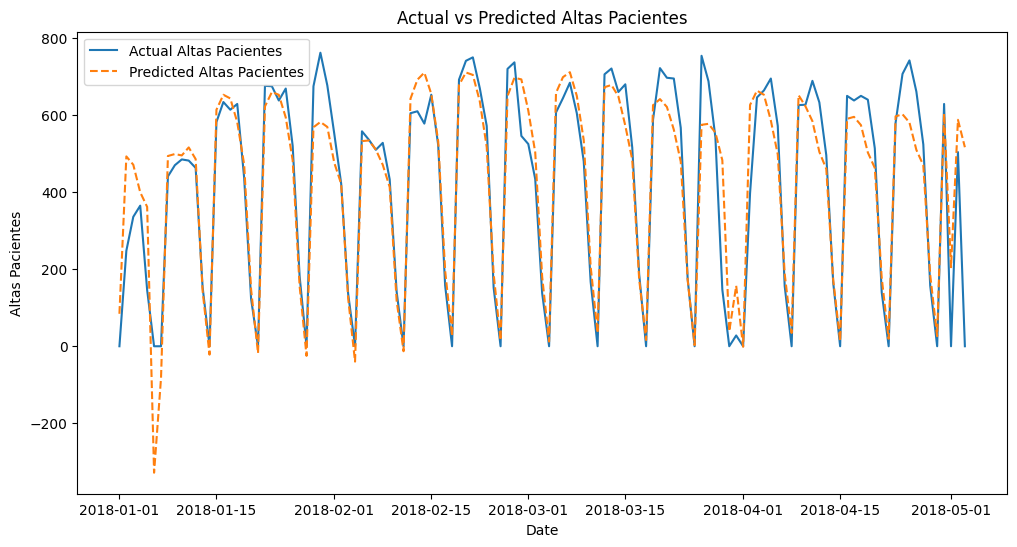

In [122]:
# Plot actual vs predicted altas_pacientes
import matplotlib.pyplot as plt

df['predicted_altas'] = model_altas.predict(X).reindex(df.index).fillna(0)
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['altas_pacientes'], label='Actual Altas Pacientes')
plt.plot(df['date'], df['predicted_altas'], label='Predicted Altas Pacientes', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Altas Pacientes')
plt.title('Actual vs Predicted Altas Pacientes')
plt.legend()
plt.show()

In [123]:
# Media Channels Contributions dataset (Altas)
params = model_altas.params

dow_cols = [c for c in X.columns if c.startswith('dow_')]
baseline_cols = [c for c in (['const', 'trend', 'is_bank_holiday'] + dow_cols) if c in X.columns and c in params.index]

baseline = (X[baseline_cols].mul(params[baseline_cols], axis=1).sum(axis=1) if baseline_cols else 0)

altas_contributions_df = pd.DataFrame({
    'date': df['date'],
    'radio_contribution': params.get('radio_grps20_adstock', 0) * df['radio_grps20_adstock'],
    'tv_contribution': params.get('tv_grps20_adstock', 0) * df['tv_grps20_adstock'],
    'baseline': baseline,
})

altas_contributions_df['total_predicted'] = altas_contributions_df[['radio_contribution', 'tv_contribution', 'baseline']].sum(axis=1)
altas_contributions_df.head()

,date,radio_contribution,tv_contribution,baseline,total_predicted
0,2018-01-01,2.014403,0.0,82.240672,84.255076
1,2018-01-02,1.410082,0.0,491.425794,492.835877
2,2018-01-03,0.987058,0.0,470.177423,471.16448
3,2018-01-04,0.690940,0.0,399.009428,399.700368
4,2018-01-05,2.665929,0.0,359.143996,361.809925


### Modelo contactos

In [124]:
# Fit OLS regression model (Contactos)
y = pd.to_numeric(df['contactos'], errors='coerce')

# Drop any rows with missing values after coercion
mask = y.notna() & X.notna().all(axis=1)
y_fit = y.loc[mask].astype(float)
X_fit = X.loc[mask].astype(float)

model = sm.OLS(y_fit, X_fit).fit()
model_contactos = model
print(model_contactos.summary())

                            OLS Regression Results                            
Dep. Variable:              contactos   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     53.93
Date:                Mon, 19 Jan 2026   Prob (F-statistic):           3.55e-38
Time:                        17:17:05   Log-Likelihood:                -798.02
No. Observations:                 123   AIC:                             1618.
Df Residuals:                     112   BIC:                             1649.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  532.1103 

/tmp/ipykernel_75628/2995615943.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['predicted_contactos'] = model_contactos.predict(X).reindex(df.index).fillna(0)


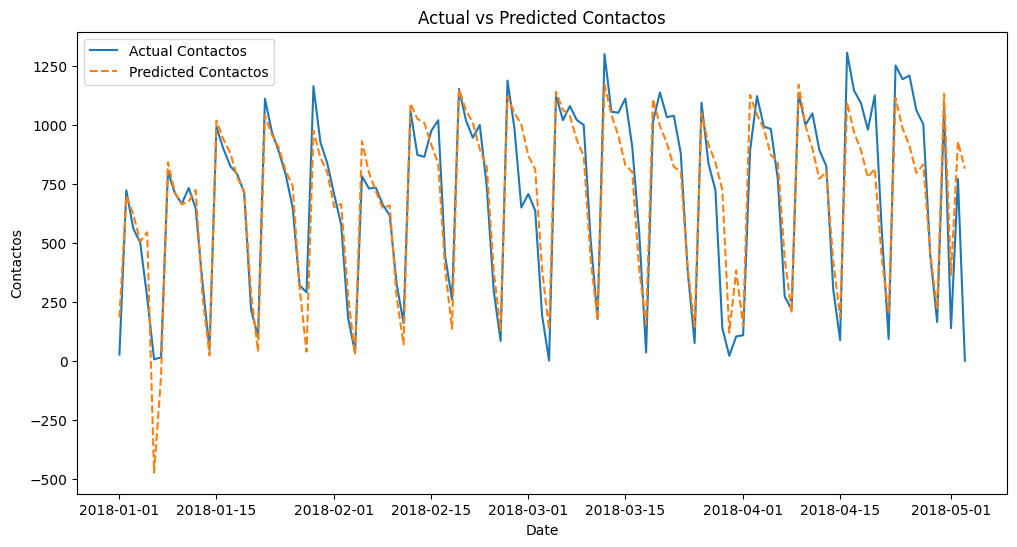

In [125]:
# Plot actual vs predicted contactos
import matplotlib.pyplot as plt

df['predicted_contactos'] = model_contactos.predict(X).reindex(df.index).fillna(0)
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['contactos'], label='Actual Contactos')
plt.plot(df['date'], df['predicted_contactos'], label='Predicted Contactos', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Contactos')
plt.title('Actual vs Predicted Contactos')
plt.legend()
plt.show()

In [126]:
# Media Channels Contributions dataset (Contactos)
params = model_contactos.params

dow_cols = [c for c in X.columns if c.startswith('dow_')]
baseline_cols = [c for c in (['const', 'trend', 'is_bank_holiday'] + dow_cols) if c in X.columns and c in params.index]

baseline = (X[baseline_cols].mul(params[baseline_cols], axis=1).sum(axis=1) if baseline_cols else 0)

contactos_contributions_df = pd.DataFrame({
    'date': df['date'],
    'radio_contribution': params.get('radio_grps20_adstock', 0) * df['radio_grps20_adstock'],
    'tv_contribution': params.get('tv_grps20_adstock', 0) * df['tv_grps20_adstock'],
    'baseline': baseline,
})

contactos_contributions_df['total_predicted'] = contactos_contributions_df[['radio_contribution', 'tv_contribution', 'baseline']].sum(axis=1)
contactos_contributions_df.head()

,date,radio_contribution,tv_contribution,baseline,total_predicted
0,2018-01-01,2.977236,0.0,182.788065,185.765302
1,2018-01-02,2.084065,0.0,696.673222,698.757288
2,2018-01-03,1.458846,0.0,621.342196,622.801042
3,2018-01-04,1.021192,0.0,506.115505,507.136697
4,2018-01-05,3.940174,0.0,542.511513,546.451686


In [127]:
contactos_contributions_df

,date,radio_contribution,tv_contribution,baseline,total_predicted
0,2018-01-01,2.977236e+00,0.000000,182.788065,185.765302
1,2018-01-02,2.084065e+00,0.000000,696.673222,698.757288
2,2018-01-03,1.458846e+00,0.000000,621.342196,622.801042
3,2018-01-04,1.021192e+00,0.000000,506.115505,507.136697
4,2018-01-05,3.940174e+00,0.000000,542.511513,546.451686
...,...,...,...,...,...
118,2018-04-29,3.186346e-06,0.000089,221.370379,221.370471
119,2018-04-30,2.230442e-06,0.000044,1133.228813,1133.228859
120,2018-05-01,1.561309e-06,0.000022,365.104277,365.104301
121,2018-05-02,1.092917e-06,0.000011,930.778097,930.778109


In [129]:
# Save contributions to processed files (CSV + Parquet)
from pathlib import Path

output_dir = Path(data_path) / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

# CSV
altas_csv = output_dir / 'altas_contributions.csv'
contactos_csv = output_dir / 'contactos_contributions.csv'
altas_contributions_df.to_csv(altas_csv, index=False)
contactos_contributions_df.to_csv(contactos_csv, index=False)

# Parquet (try pyarrow first; fall back to fastparquet)
altas_parquet = output_dir / 'altas_contributions.parquet'
contactos_parquet = output_dir / 'contactos_contributions.parquet'

for df_name, df_obj, path in [
    ('altas_contributions_df', altas_contributions_df, altas_parquet),
    ('contactos_contributions_df', contactos_contributions_df, contactos_parquet),
 ]:
    try:
        df_obj.to_parquet(path, index=False, engine='pyarrow')
    except Exception as e:
        print(f"pyarrow parquet failed for {df_name} ({type(e).__name__}: {e}); falling back to fastparquet")
        df_obj.to_parquet(path, index=False, engine='fastparquet')

print('Wrote:', altas_csv)
print('Wrote:', contactos_csv)
print('Wrote:', altas_parquet)
print('Wrote:', contactos_parquet)

pyarrow parquet failed for altas_contributions_df (ArrowKeyError: A type extension with name pandas.period already defined); falling back to fastparquet
pyarrow parquet failed for contactos_contributions_df (ArrowKeyError: A type extension with name pandas.period already defined); falling back to fastparquet
Wrote: data/NOVADENT/processed/altas_contributions.csv
Wrote: data/NOVADENT/processed/contactos_contributions.csv
Wrote: data/NOVADENT/processed/altas_contributions.parquet
Wrote: data/NOVADENT/processed/contactos_contributions.parquet
